In [102]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### High-level overview

In [103]:
# Load and view the dataset
df = pd.read_csv('../data/raw/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [104]:
# Separating the features from the target
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

Background: 

Features:

- age is the age of the primary beneficiary
- sex is the insurance contractor gender as male or female 
- bmi is in kg/m^2 with the ideal being 18.5 to 24.9
- children is the number of children covered by health insurance or number of dependents
- smoker is smoking as yes or no
- region is the beneficiary's residential area in the US as northeast, southeast, southwest, or northwest

Target:

- charges is the individual medical cost billed by health insurance

There are 7 columns and 1338 rows. The target column is charges, and we have a mix of numeric and non-numeric columns to predict it.

#### First look into target

<Axes: xlabel='charges', ylabel='Count'>

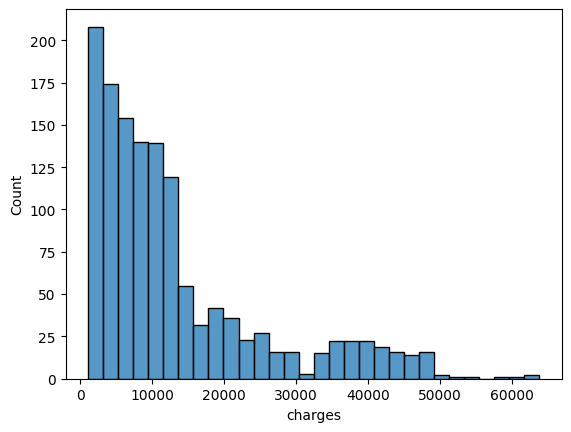

In [105]:
sns.histplot(y)

We see that there is a right skewed with bumps around 10k, just before 20k and another around mid 30k to 40k.

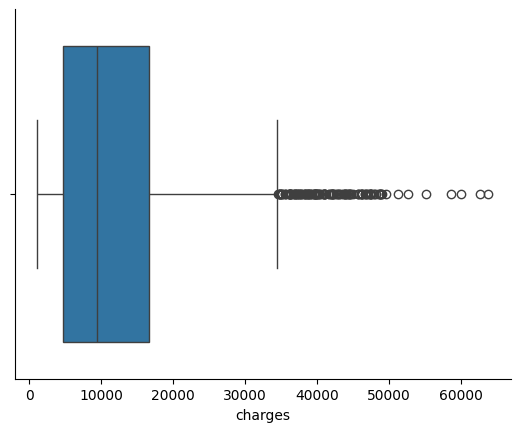

In [106]:
sns.boxplot(x=y)
sns.despine();

Median is about 10k with outliers on the far right.

<Axes: ylabel='charges'>

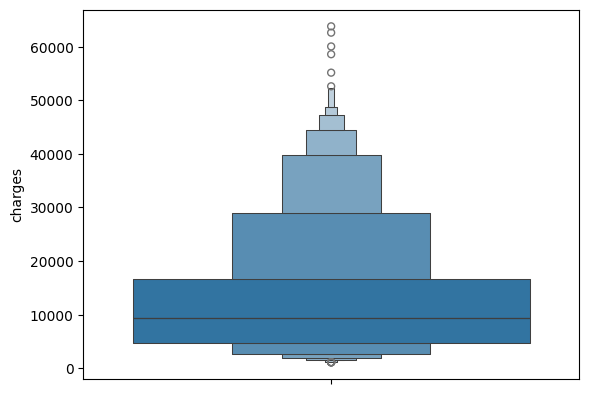

In [107]:
sns.boxenplot(y)

In [108]:
y.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

The range of values are from around 1121.87 to around 63770.43.

Most values are around 4740.29 to 16639.91.

The median is 9382.033 and the mean is about 13270.42, reflecting the right skew from the mean pulled to the right.

#### First look into features

##### Numeric

In [109]:
# Separate features between numeric and non-numeric
num_feat = X.select_dtypes(include='number')
cat_feat = X.select_dtypes(exclude='number')

print(f'Numerical Features: \n {num_feat.head()} \n')
print(f'Categorical Features: \n {cat_feat.head()}')

Numerical Features: 
    age     bmi  children
0   19  27.900         0
1   18  33.770         1
2   28  33.000         3
3   33  22.705         0
4   32  28.880         0 

Categorical Features: 
       sex smoker     region
0  female    yes  southwest
1    male     no  southeast
2    male     no  southeast
3    male     no  northwest
4    male     no  northwest


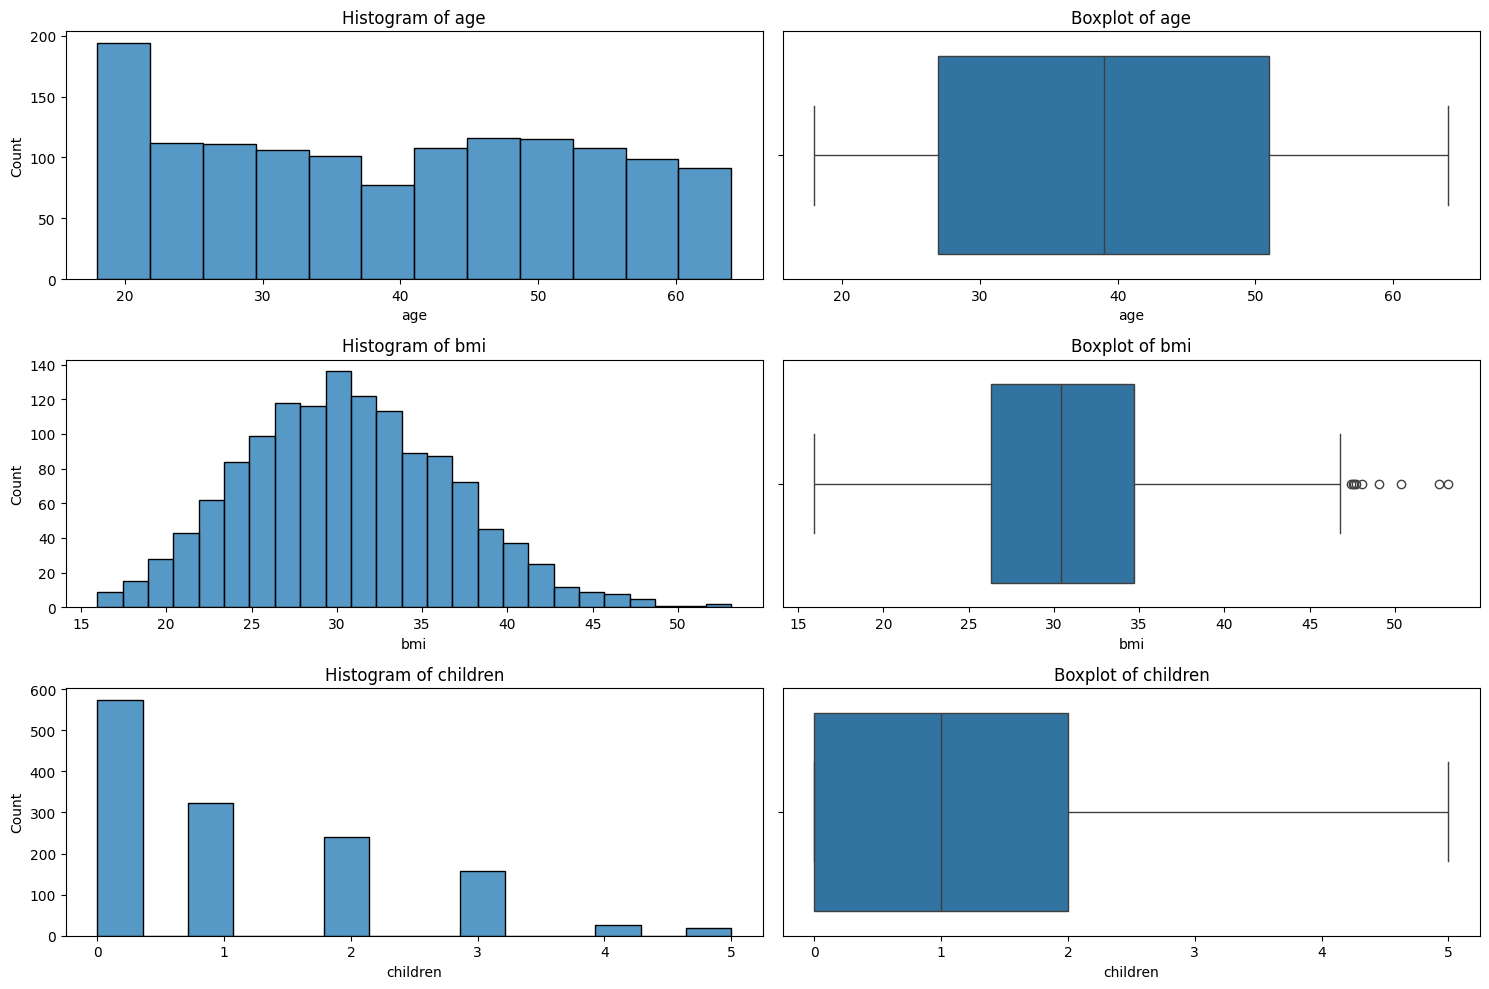

In [110]:
fig, axes = plt.subplots(num_feat.shape[1],2,figsize=(15,10))

for i, col in enumerate(num_feat.columns):

    sns.histplot(data=num_feat, x=col, ax = axes[i,0])
    axes[i,0].set_title(f'Histogram of {col}')

    sns.boxplot(data=num_feat, x=col, ax = axes[i,1])
    axes[i,1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()



In [111]:
num_feat.describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


Age is like a uniform distribution but it deviates from it with a mode around 20 and a dip around 40 years of age.

Bmi is a bell-shape distribution but has a right skew with a median of 30.4 and mean about 30.66 and a std of around 6.10.

Children is shaped like an exponential decay with most having 0 children. 

##### Categorical

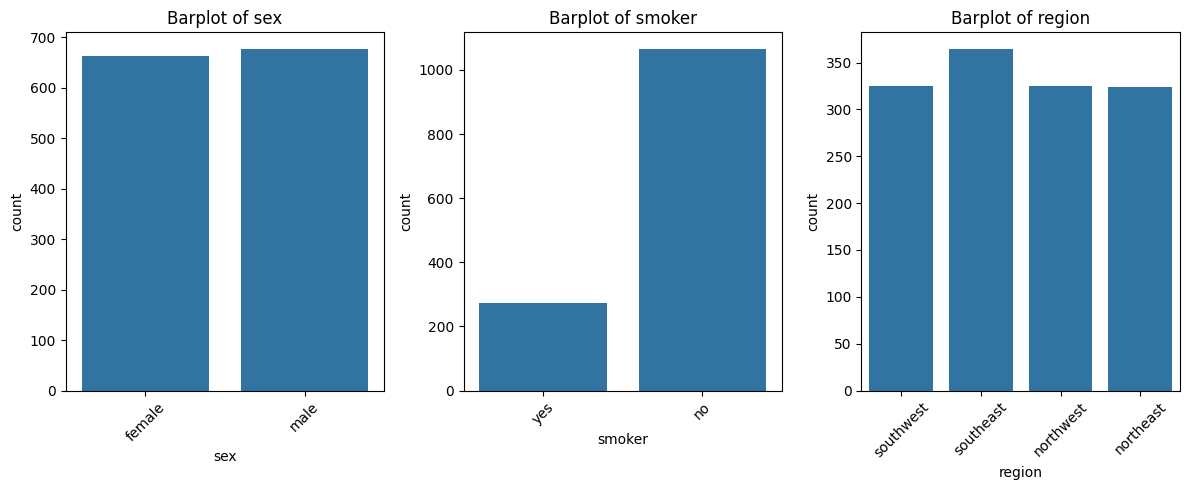

In [113]:
cat_n_cols = cat_feat.shape[1]

# squeeze is True by default and needs to be False to make this work
fig, axes = plt.subplots(1,cat_n_cols,figsize=(4*cat_n_cols,5),squeeze=False)

for i, col in enumerate(cat_feat.columns):
    sns.countplot(data=cat_feat, x=col, ax=axes[0,i])
    axes[0,i].set_title(f'Barplot of {col}')
    axes[0,i].tick_params(axis='x',rotation=45)

plt.tight_layout()
plt.show()

In [115]:
for i in cat_feat.columns:
    print(cat_feat[i].value_counts(normalize=True),'\n')

sex
male      0.505232
female    0.494768
Name: proportion, dtype: float64 

smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64 

region
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: proportion, dtype: float64 



We want to know if there are any rare categories (<1-5%). There is none, so we do not need to aggregate.

## Basic Data Check: 
1. Missing
2. Duplicates
3. Data types
4. Outliers 
5. Categorical encoding
6. Feature scaling

### 1. Missing Data

In [111]:
# Check the status of missing data
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

At a surface level it looks like there is no missing data, but there could be a filler value for missing data.

In [112]:
# Are there any sentinel #'s like -1 or 999 as a placeholder for "missing value"?
print('Numeric column distribution at a glance:')
print('=========================================')
num_cols = df.select_dtypes(include="number").columns.to_list()
df.describe()

Numeric column distribution at a glance:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


With the numeric columns there are no values like -1 for the min value or 999 in the max would be placeholders for missing data.

In [113]:
non_num_cols = df.select_dtypes(exclude="number").columns.to_list()

print('Non-numeric column unique values:')
print('=================================')
for i in non_num_cols:
    print(df[i].value_counts(),"\n")

Non-numeric column unique values:
sex
male      676
female    662
Name: count, dtype: int64 

smoker
no     1064
yes     274
Name: count, dtype: int64 

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64 



For the non-numeric columns, I do not see any potential missing data indicator as a category.

There is no noticeable missing data.

### 2. Duplicates

In [114]:
num_dup = df.duplicated().sum()
print(f"The number of duplicates: {num_dup}\n")
dup_rows = df[df.duplicated(keep=False)]
print(dup_rows)

The number of duplicates: 1

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


One exact duplicate exists out of the 1338 rows. If there were more examples, the row count frequency could have meaning such as logs, transactions, or time series which could be aggregated. However, since there is only one, I will choose to remove it. 

In [115]:
df_unique = df.drop_duplicates()
print(f"The value counts of duplicates:\n {df_unique.duplicated().value_counts()}")
print(f"The shape: {df_unique.shape}")

The value counts of duplicates:
 False    1337
Name: count, dtype: int64
The shape: (1337, 7)


In [116]:
# Reset the index
df = df_unique.reset_index(drop=True)

### 3. Data Types

Right here we need to be aware of semantic data type. Meaning we want to match the variable data type for what it truly means in the real world.

In [117]:
print(df.select_dtypes(include='number').dtypes)
df.select_dtypes(include='number')

age           int64
bmi         float64
children      int64
charges     float64
dtype: object


,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1332,50,30.970,3,10600.54830
1333,18,31.920,0,2205.98080
1334,18,36.850,0,1629.83350
1335,21,25.800,0,2007.94500


In [118]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


age, bmi, children, and charges have appropriate datatypes that are representative.

In [119]:
print(df.select_dtypes(exclude='number').dtypes)
df.select_dtypes(exclude='number')

sex       object
smoker    object
region    object
dtype: object


,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1332,male,no,northwest
1333,female,no,northeast
1334,female,no,southeast
1335,female,no,southwest


In [120]:
for i in non_num_cols:
    print(df[i].value_counts(),"\n")

sex
male      675
female    662
Name: count, dtype: int64 

smoker
no     1063
yes     274
Name: count, dtype: int64 

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64 



There are no numeric columns disguised as an object column like "1" or "NA". There are no mixed datatypes either.

However, later these columns should be encoded to be numerical. Given the logic, there they are nominal, so one-hot encoding would work.

Moreover, the cardinality is not high and there are no rare categories to aggregate.

### 4. Outliers

In [121]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Column: age
Q1 is 27.0
Q3 is 51.0
IQR is 24.0
Above 87.0 is an outlier
Below -9.0 is an outlier 



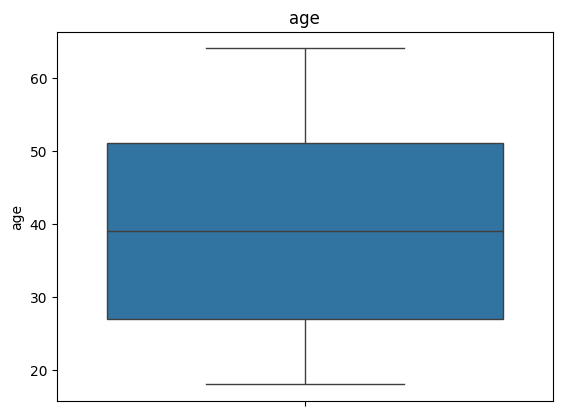

Column: bmi
Q1 is 26.29
Q3 is 34.7
IQR is 8.410000000000004
Above 47.31500000000001 is an outlier
Below 13.674999999999994 is an outlier 



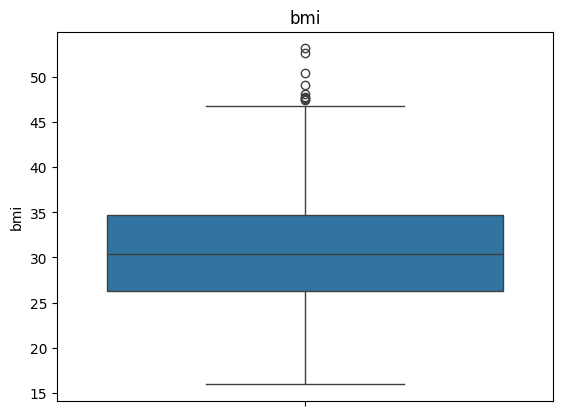

Column: children
Q1 is 0.0
Q3 is 2.0
IQR is 2.0
Above 5.0 is an outlier
Below -3.0 is an outlier 



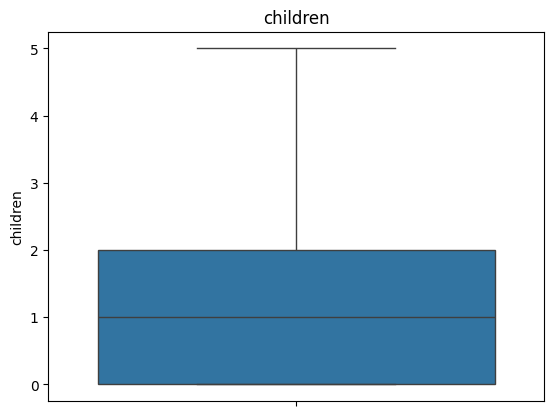

Column: charges
Q1 is 4746.344
Q3 is 16657.71745
IQR is 11911.37345
Above 34524.777625 is an outlier
Below -13120.716174999998 is an outlier 



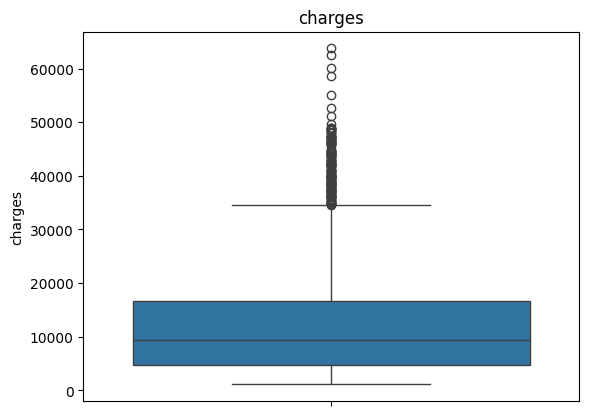

In [122]:
for i in num_cols:
    q1, q3 = np.percentile(df.loc[:,i],[25,75])
    IQR = q3-q1
    print(f"Column: {i}")
    print(f"Q1 is {q1}")
    print(f"Q3 is {q3}")
    print(f"IQR is {IQR}")
    print(f"Above {(1.5*IQR)+q3} is an outlier")
    print(f"Below {q1-(1.5*IQR)} is an outlier \n")

    sns.boxplot(df[i])
    plt.title(f"{i}")
    plt.ylabel(f"{i}")
    plt.show()

bmi and charges both have right skews leading to outliers. We can log transform these categories later with feature scaling.

In [123]:
for j in non_num_cols:
    print(f"Column: {j}")
    print(df.loc[:,j].value_counts(normalize=True),"\n")

Column: sex
sex
male      0.504862
female    0.495138
Name: proportion, dtype: float64 

Column: smoker
smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: float64 

Column: region
region
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: proportion, dtype: float64 



There is no category among the non-numeric variables that have <1-5% or rare categories.

Before categorical encoding and feature scaling, I want to train-test-split the dataset to prevent data leakage.


### 5. Categorical Encoding

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [125]:
X = df.iloc[:,:-1]
y= df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train[non_num_cols]

,sex,smoker,region
1113,male,no,northeast
967,male,no,northeast
598,female,no,northwest
170,male,no,southeast
275,female,no,northeast
...,...,...,...
1095,female,yes,northeast
1130,male,no,southwest
1294,male,no,southwest
860,female,no,southwest


In [127]:
# We want to one hot encode sex, smoker, and region which are nominal variables with low cardinality.
ohe = OneHotEncoder(handle_unknown='ignore',drop='first',sparse_output=False).set_output(transform='pandas')
X_train_cat = ohe.fit_transform(X_train[non_num_cols])
X_test_cat = ohe.transform(X_test[non_num_cols])

In [128]:
X_train_cat

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1113,1.0,0.0,0.0,0.0,0.0
967,1.0,0.0,0.0,0.0,0.0
598,0.0,0.0,1.0,0.0,0.0
170,1.0,0.0,0.0,1.0,0.0
275,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1095,0.0,1.0,0.0,0.0,0.0
1130,1.0,0.0,0.0,0.0,1.0
1294,1.0,0.0,0.0,0.0,1.0
860,0.0,0.0,0.0,0.0,1.0


In [129]:
X_train = pd.concat([X_train,X_train_cat],axis=1).drop(columns=['sex','smoker','region'])
X_test = pd.concat([X_test,X_test_cat],axis=1).drop(columns=['sex','smoker','region'])

In [130]:
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1113,23,24.510,0,1.0,0.0,0.0,0.0,0.0
967,21,25.745,2,1.0,0.0,0.0,0.0,0.0
598,52,37.525,2,0.0,0.0,1.0,0.0,0.0
170,63,41.470,0,1.0,0.0,0.0,1.0,0.0
275,47,26.600,2,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1095,51,34.960,2,0.0,1.0,0.0,0.0,0.0
1130,27,45.900,2,1.0,0.0,0.0,0.0,1.0
1294,20,22.000,1,1.0,0.0,0.0,0.0,1.0
860,38,28.000,3,0.0,0.0,0.0,0.0,1.0


### 6. Feature Scaling

We suspect right skew, let's plot a histogram to see. Then we can log transform bmi (within X) and charges (y).

#### bmi

Text(0.5, 1.0, 'Histogram of Bmi')

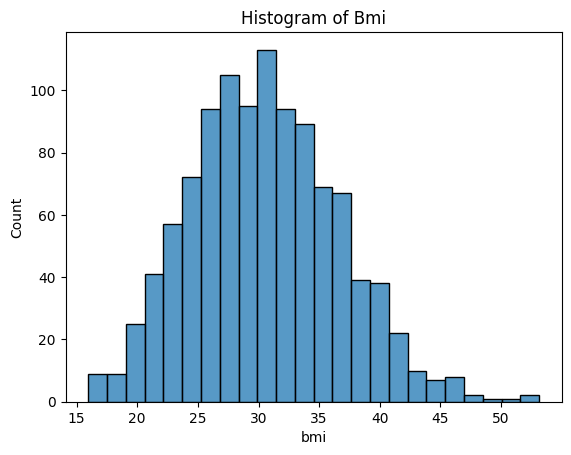

In [131]:
sns.histplot(X_train,x='bmi')
plt.title('Histogram of Bmi')

We see a right skew.

Text(0.5, 1.0, 'Log of Bmi')

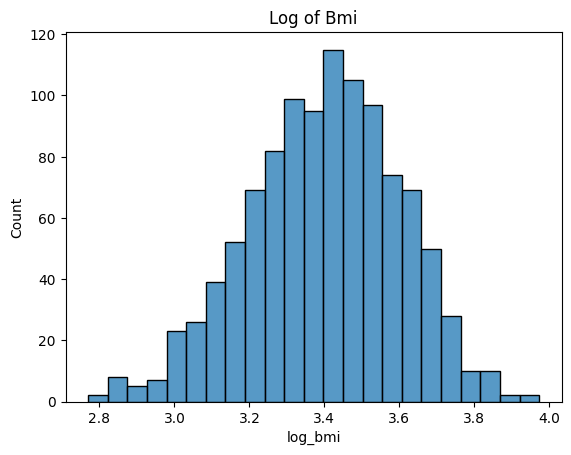

In [132]:
X_train['log_bmi'] = np.log(X_train['bmi'])
sns.histplot(X_train,x='log_bmi')
plt.title('Log of Bmi')

We now see that it is more symmetrical with less skew to the right.

In [133]:
# Drop it from X_train
X_train = X_train.drop(columns='bmi')
# Within test: transform bmi to log_bmi and drop the original bmi column
X_test['log_bmi'] = np.log(X_test['bmi'])
X_test = X_test.drop(columns=['bmi'])

#### charges

Text(0.5, 1.0, 'Histogram of Charges')

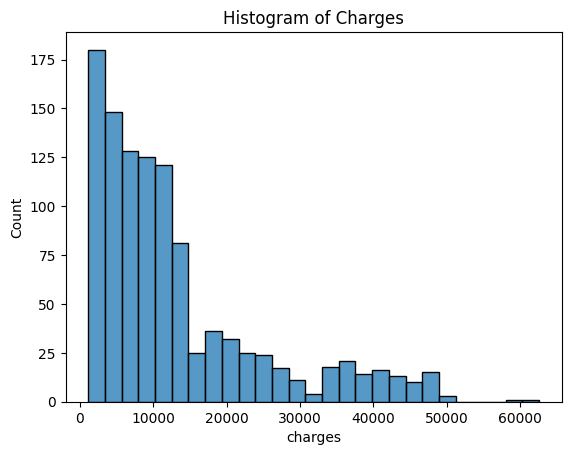

In [134]:
sns.histplot(y_train)
plt.title('Histogram of Charges')

Here we see a heavy right skew.

In [135]:
y_train = np.log(y_train)
y_train = y_train.rename('log_charges')

Text(0.5, 1.0, 'log charges')

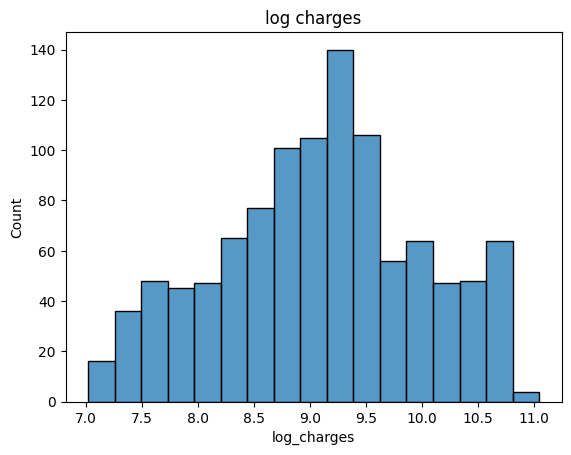

In [138]:
sns.histplot(y_train)
plt.title('log charges')

We see that the distribution is more symmetrical compared to its original heavy right skew. We can np.exp to get the original value later.

In [139]:
# Transform y_test
y_test = np.log(y_test)
y_test = y_test.rename('log_charges')

In [ ]:
# Save data after basic data check
# X_train.to_csv('../data/interim/X_train.csv',index=False)
# X_test.to_csv('../data/interim/X_test.csv',index=False)
# y_train.to_csv('../data/interim/y_train.csv',index=False)
# y_test.to_csv('../data/interim/y_test.csv',index=False)

### Feature vs Feature

### Feature vs Target